------
# Introdução

> Olá! Seja bem-vindo.
> 
> Quem nunca ficou curioso por tentar prever o valor da gasolina amanhã? Será possível? Esse projeto terá esse objetivo.
> Iremos analisar dados históricos desses valores, mais precisamente um recorte do ano de 2013 até 2020. Analisando possíveis padrões existentes, e por fim modelando uma ferramenta que nos ajude a prever os valores futuros desse produto.
>
> `Links dos Dados Originais:`
> 
> [Série Histórica Combustíveis](https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-e-de-glp)
> 
> [IPCA - Inflação](https://brasilindicadores.com.br/ipca)



# Importando Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime as dt
import time
import scipy
import requests
from bs4 import BeautifulSoup as bs4

# Carregando Dados e criando Funções (Leitura e Ajustes)

In [2]:
def read_data(tipo_produto: str, path: str):
    files_name = os.listdir(path)
    df = pd.DataFrame()
    
    for file in files_name:
        df_temp = pd.read_csv(path + file, sep=';', parse_dates=True, encoding='utf-8', low_memory=False)
        df = pd.concat([df, df_temp])
    
    df = df.drop(columns=['Nome da Rua', 'Numero Rua', 'Complemento', 'Cep', 'Unidade de Medida'])
    nomes_colunas = {
                    'Estado - Sigla':'EstadoSigla',
                    'Municipio':'Municipio',
                    'Revenda':'Revenda',
                    'CNPJ da Revenda':'CNPJRevenda',
                    'Bairro':'Bairro',
                    'Produto':'Produto',
                    'Data da Coleta':'DataColeta',
                    'Valor de Venda':'ValorVenda',
                    'Valor de Compra':'ValorCompra',
                    'Bandeira':'Bandeira'
                     }

    df = df.rename(columns=nomes_colunas)
    df['Produto'] = df['Produto'].str.upper()
    return df.loc[df['Produto']==tipo_produto]

def float_converter(colunas, dataframe):
    for coluna in colunas:
        try:
            dataframe[coluna] = dataframe[coluna].str.replace(',','.').astype(float)
            print(f'{coluna} convertido com sucesso para {column_type}')
        except:
            column_type = type(dataframe[coluna].dtype)
            print(f'Uma excessão ocorreu porque {coluna} é do tipo {column_type}')
            
def add_dates(colunas, dataframe):
    for coluna in colunas:
        dataframe[coluna] = pd.to_datetime(dataframe[coluna],format='mixed')
        dataframe['mes'] = dataframe[coluna].dt.month.astype(int)
        dataframe['ano'] = dataframe[coluna].dt.year.astype(int)
        dataframe['dia'] = dataframe[coluna].dt.day.astype(int)
    return 'Datas Adicionadas'
        
def add_mrg(coluna_venda, coluna_compra, dataframe):
    dataframe['mrg'] = (dataframe[coluna_venda] - dataframe[coluna_compra])/dataframe[coluna_venda]
    return 'Coluna Margem Adicionada'    


In [3]:
#Código Hexadecimal de cores
cor_roxo_padrao = '#5b6aea'
cor_roxo_claro = '#8c96f0'
cor_roxo_escuro = '#1b1f46'

In [4]:
combustiveis = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_historicos/')

#Conversões de tipo de dados
float_converter(['ValorCompra','ValorVenda'], combustiveis)
add_dates(['DataColeta'], combustiveis)

#Calculando Margem de lucro
add_mrg('ValorVenda', 'ValorCompra', combustiveis)

Uma excessão ocorreu porque ValorCompra é do tipo <class 'numpy.dtypes.Float64DType'>
ValorVenda convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


'Coluna Margem Adicionada'

In [5]:
colunas_quantitativas = ['ValorVenda', 'ValorCompra', 'mrg']

# Visão Geral dos Dados

In [6]:
combustiveis.isnull().sum()

Regiao - Sigla          0
EstadoSigla             0
Municipio               0
Revenda                 0
CNPJRevenda             0
Bairro               8278
Produto                 0
DataColeta              0
ValorVenda              0
ValorCompra       1573394
Bandeira                0
mes                     0
ano                     0
dia                     0
mrg               1573394
dtype: int64

In [7]:
combustiveis[colunas_quantitativas].describe().round(3)

,ValorVenda,ValorCompra,mrg
count,2498692.000,925298.000,925298.000
mean,4.024,3.189,0.130
std,1.062,0.627,0.039
min,2.229,2.025,-0.163
25%,3.139,2.564,0.103
50%,3.890,3.170,0.129
75%,4.540,3.710,0.155
max,8.990,5.091,0.414


In [8]:
combustiveis = combustiveis.dropna(axis = 0) #Tirando valores nulos

In [9]:
combustiveis[colunas_quantitativas].describe().round(3)

,ValorVenda,ValorCompra,mrg
count,922235.000,922235.000,922235.000
mean,3.659,3.189,0.130
std,0.672,0.627,0.039
min,2.229,2.025,-0.163
25%,2.999,2.564,0.103
50%,3.669,3.170,0.129
75%,4.190,3.710,0.155
max,5.799,5.091,0.414


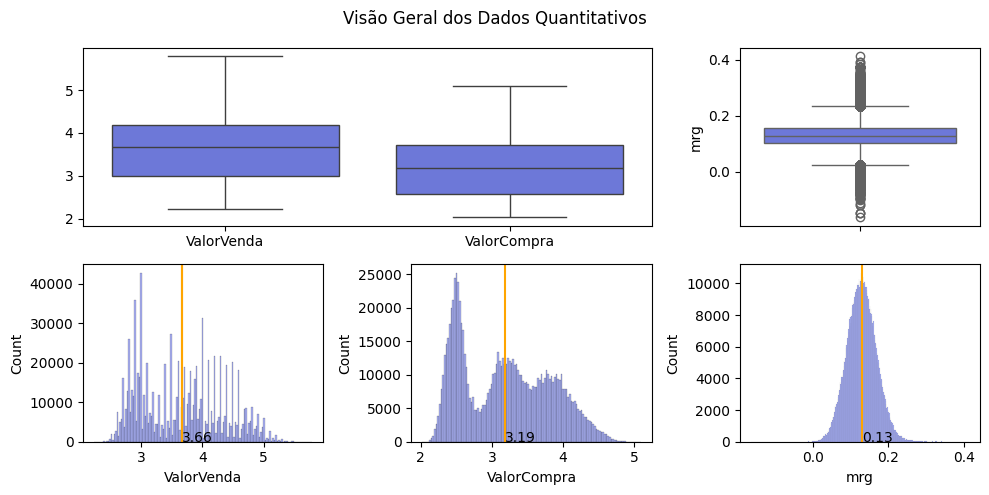

In [10]:
plt.figure(figsize = (10, 5)).suptitle('Visão Geral dos Dados Quantitativos')

plt.subplot(2, 3, (1, 2))
sb.boxplot(combustiveis[colunas_quantitativas[0:2]], color = cor_roxo_padrao)

plt.subplot(2, 3, (3))
sb.boxplot(combustiveis[colunas_quantitativas[-1]], color = cor_roxo_padrao)

plt.subplot(2, 3, (4))
sb.histplot(combustiveis['ValorVenda'], color = cor_roxo_claro)
media = combustiveis['ValorVenda'].mean()
plt.axvline(media, color = 'orange')
plt.text(x = media, y = 0, s = round(media, 2))
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (5))
sb.histplot(combustiveis['ValorCompra'], color = cor_roxo_claro)
media = combustiveis['ValorCompra'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (6))
sb.histplot(combustiveis['mrg'], color = cor_roxo_claro)
media = combustiveis['mrg'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.tight_layout()
plt.savefig('visao_geral_dados_quant.png', dpi = 150)
plt.show()

## Distribuição dos Dados - Geral
>Já observamos alguns pontos interessantes.
>  
>- Temos um pico nos valores a esquerda da nossa distribuição deos valores de venda e compra (valores mais baixos).
>  
>- Temos uma amplitude alta nesse contexto, variamos de valores de compra de `R$2,025` para `R$5,091` e na venda de `R$2,229` para `R$5,799`.
>  
>- Essa variação faz com que **não possamos tomar a `média geral de compra e venda` como um boa representação dos nossos dados. Pelo menos não no cenário geral**
>
>- Contundo, a `margem de lucro` possui uma distribuição muito semelhamente a uma distribuição normal, e uma bastante estreita, o que indica que temos muitos valores em torno de uma mesma média, 13% (0.13) nesse caso. Lembrando que o pandas/seaborn/matplotlib por padrão ignora valores nulos (N/A) no momento de criar essas visualizações. Mas como já tiramos os valores nulos anteriormente, isso não será algo a se preocupar
>
>Vamos estratificar essas distribuições em busca de outras visualizações.

# Visualização das Distribuições de dados

In [11]:
combustiveis_antes_2016 = combustiveis.loc[combustiveis.ano <= 2015]
combustiveis_depois_2016 = combustiveis.loc[combustiveis.ano > 2015]

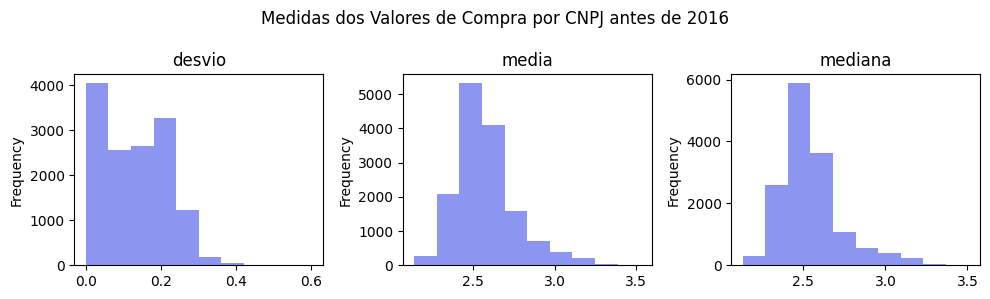

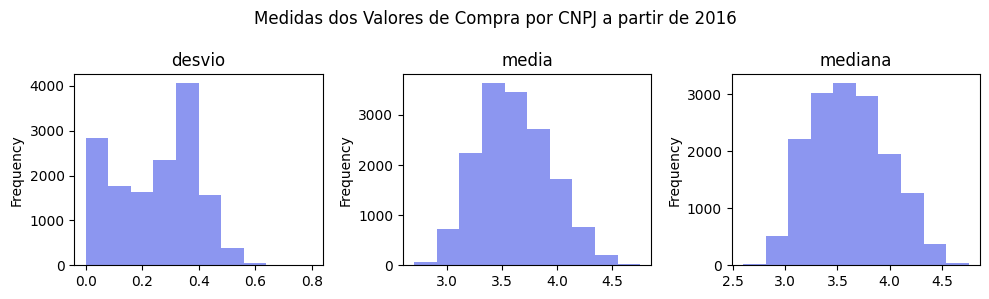

In [12]:
desvios_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].std()
mean_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].mean()
median_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por CNPJ antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.tight_layout()
plt.savefig('medidas_cnpj_antes_2016.png', dpi = 150)
plt.show()

#==========================================================================================================================================

desvios_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].std()
mean_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].mean()
median_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por CNPJ a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.tight_layout()
plt.savefig('medidas_cnpj_depois_2016.png', dpi = 150)
plt.show()

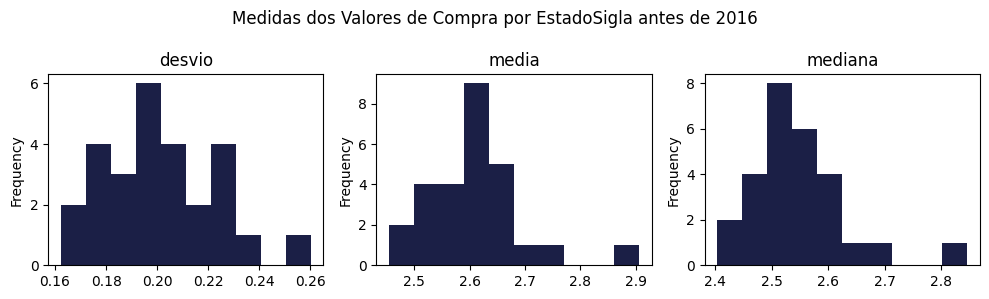

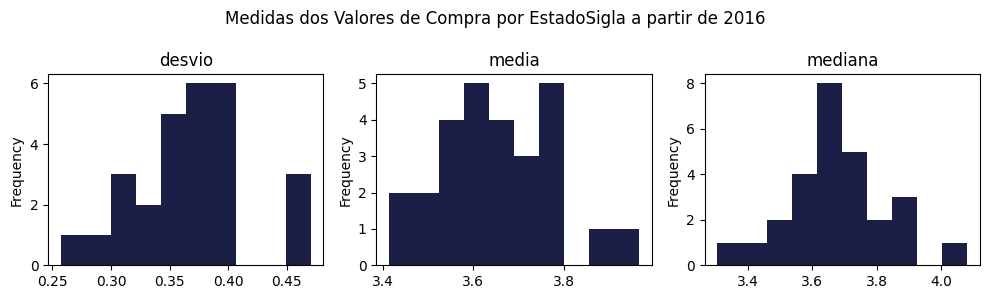

In [13]:
desvios_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].std()
mean_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].mean()
median_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por EstadoSigla antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.tight_layout()
plt.savefig('medidas_uf_antes_2016.png', dpi = 150)
plt.show()

#======================================================================================================================

desvios_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].std()
mean_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].mean()
median_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por EstadoSigla a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.tight_layout()
plt.savefig('medidas_uf_depois_2016.png', dpi = 150)
plt.show()

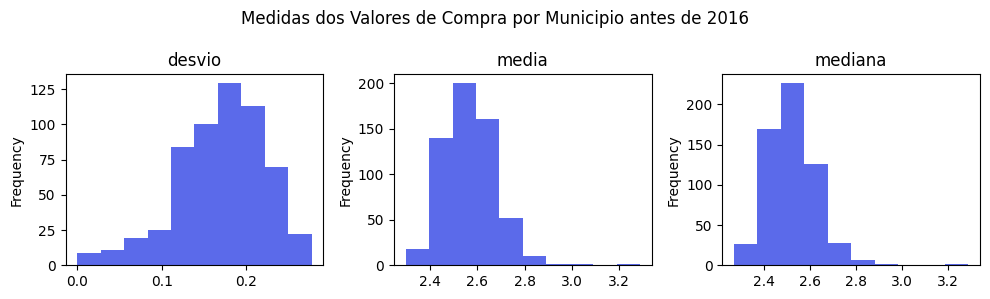

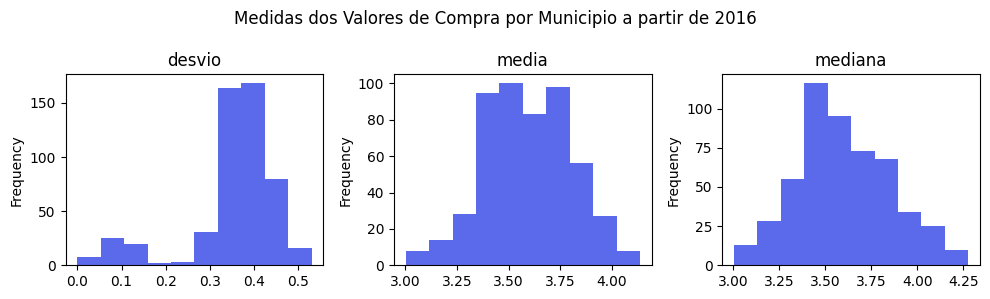

In [14]:
desvios_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].std()
mean_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].mean()
median_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por Municipio antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 2)
plt.title('media')
mean_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.tight_layout()
plt.savefig('medidas_municipio_antes_2016.png', dpi = 150)
plt.show()

#======================================================================================================================

desvios_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].std()
mean_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].mean()
median_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por Municipio a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 2)
plt.title('media')
mean_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.tight_layout()
plt.savefig('medidas_municipio_depois_2016.png', dpi = 150)
plt.show()

# Visualização da Série Temporal

### Evolução Geral

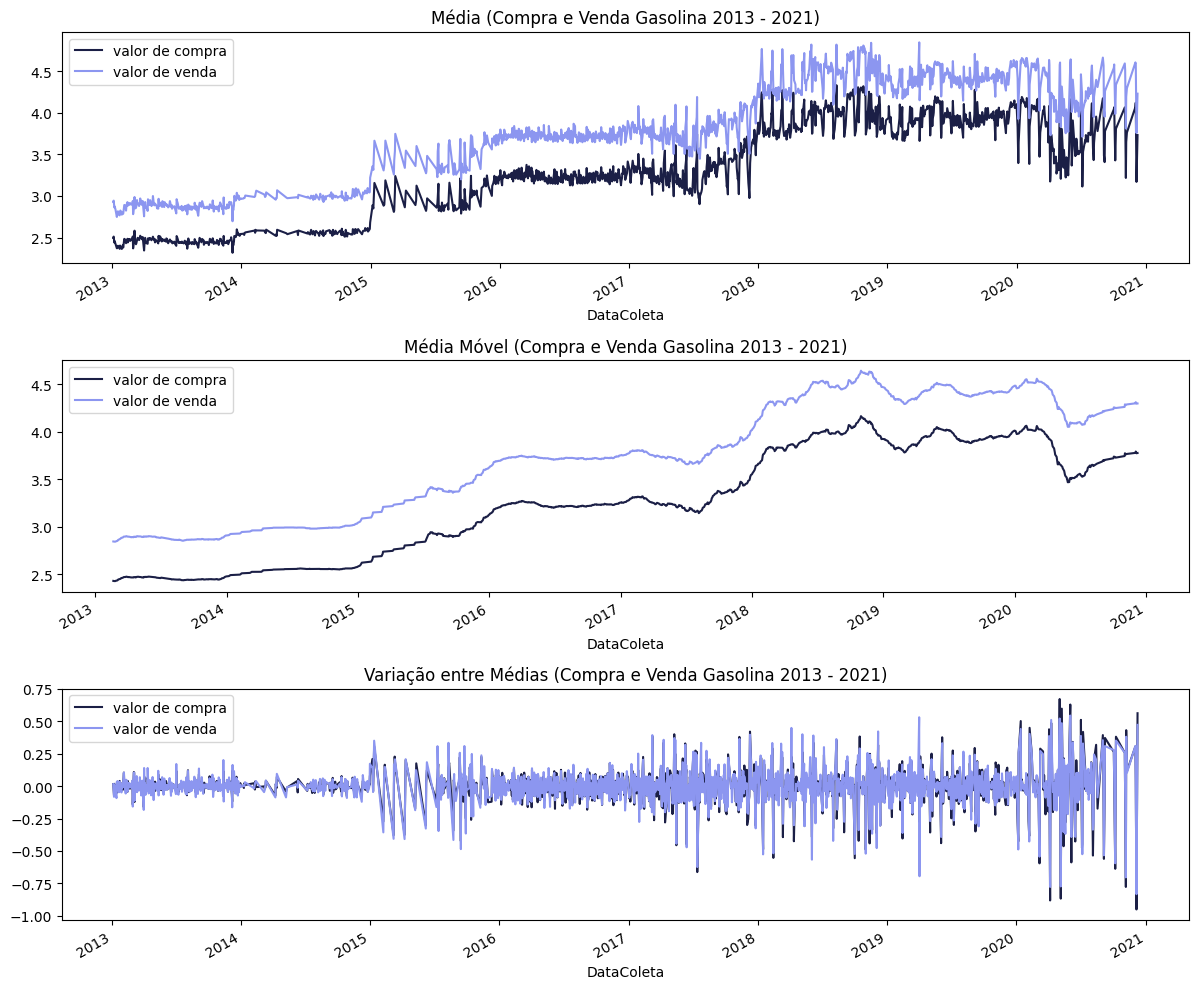

In [15]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorVenda'].mean()

num_rows = 3
num_col = 1

plt.figure(figsize = (12, 10))

plt.subplot(num_rows, num_col, 1)
plt.title('Média (Compra e Venda Gasolina 2013 - 2021)')
media_compra.plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col ,2)
plt.title('Média Móvel (Compra e Venda Gasolina 2013 - 2021)')
media_compra.rolling(30).mean().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.rolling(30).mean().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col, 3)
plt.title('Variação entre Médias (Compra e Venda Gasolina 2013 - 2021)')
media_compra.diff().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.diff().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.tight_layout()
plt.savefig('analise_serie.png', dpi=150)
plt.show()


#### Conclusões
> - Os `valores de venda` acompanham de maneira quase idêntica a evolução dos `valores de compra`, o que indica que esse produto tende a seguir uma margem fixa de lucro. Isso pode nos auxiliar a lidar com os valores nulos encontrados anteriormente.
>
> - Até 2014 os números pareciam não sofrer grandes variações, em 2015 começamos a enxergar tendências de aumento, em 2016 o aumento se mostra mais e mais significativo.
>
> - Temos uma queda acentuada na metade do ano 2020.

### Evolução por estado (UF)

In [16]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'EstadoSigla'])['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'EstadoSigla'])['ValorVenda'].mean()

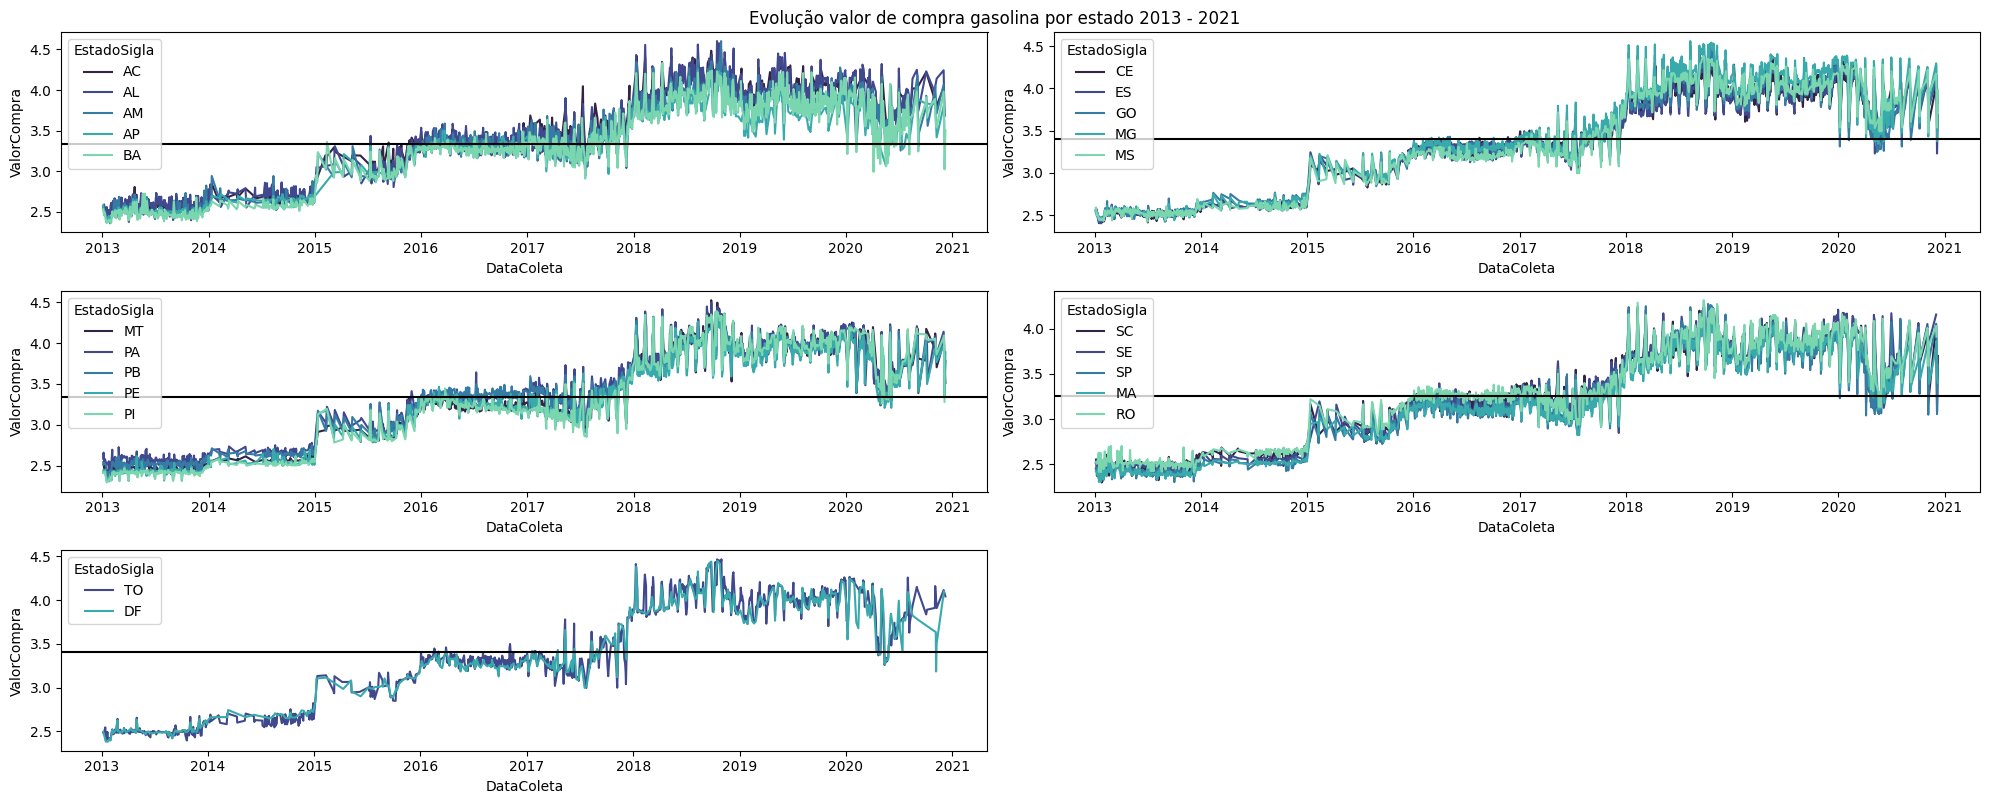

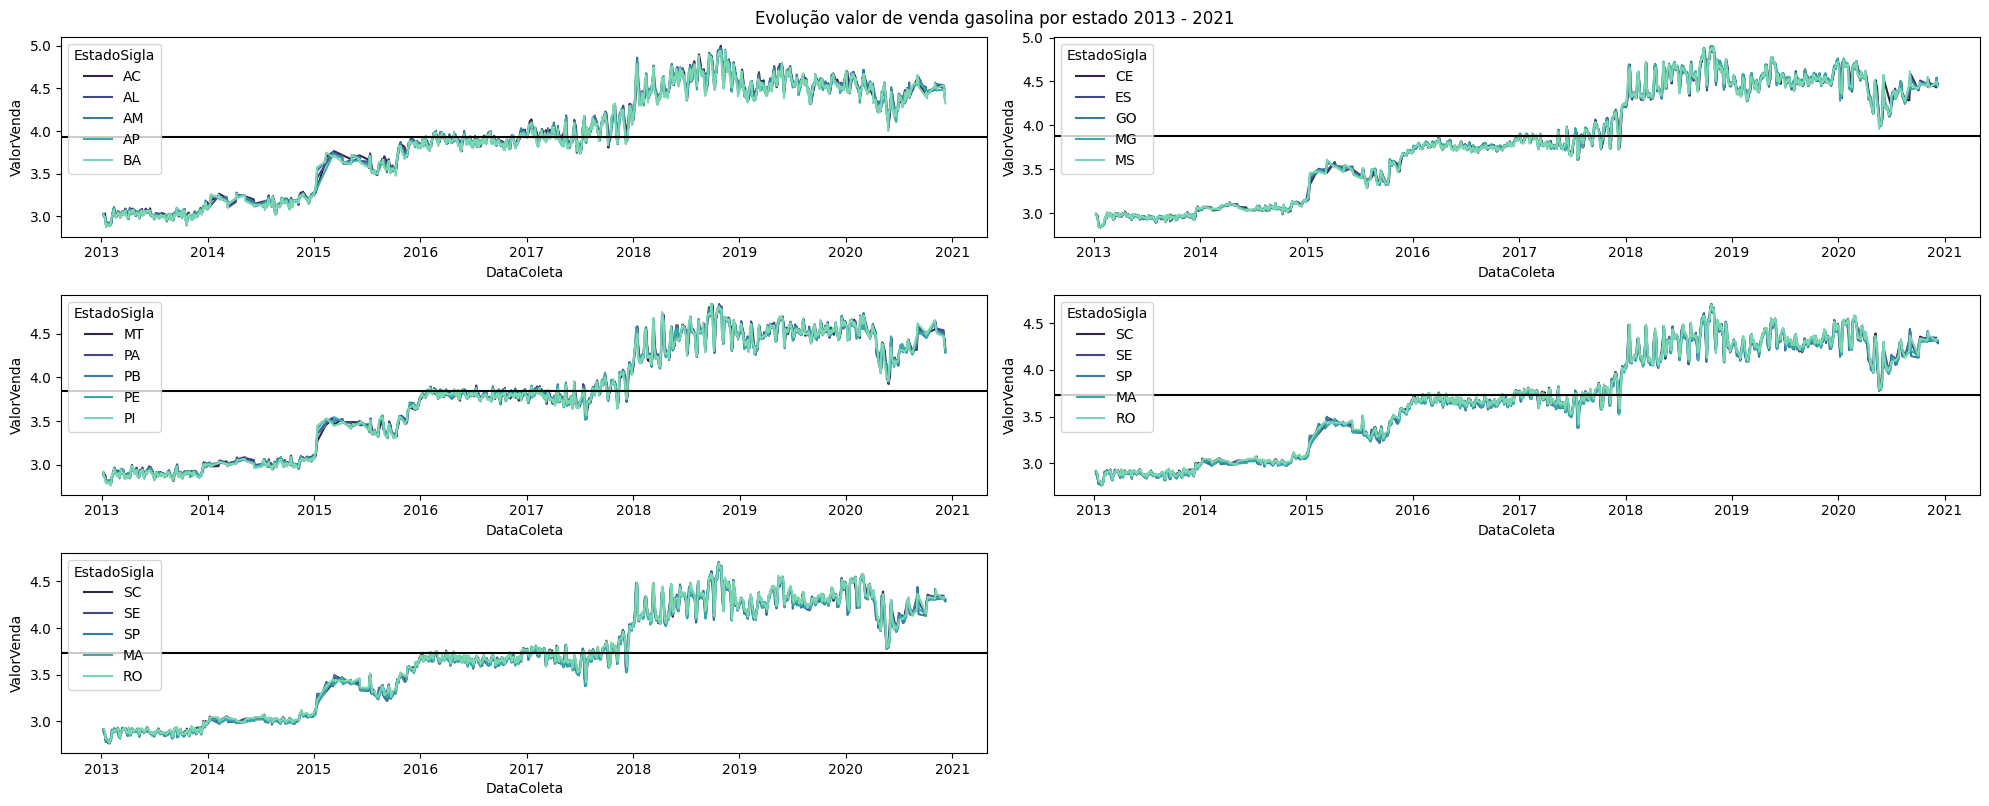

In [17]:
#Pegando 27 Estados
estados = list(media_compra.index.get_level_values(1).unique()) 

#==================================================================================================================================

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por estado 2013 - 2021')
mv_av_periods = 2

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_estado.png', dpi = 150)
plt.show()


#==================================================================================================================================


plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por estado 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
tt = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_estado.png', dpi = 150)
plt.show()

#### Conclusões
> - Notou que o formato de todos os gráficos é muito semelhante? Isso é um forte de indício que esses valores não são fortemente influênciados pelo estado, mas sim pelo passagem to tempo em si, pois a evolução vista é praticamente a mesma observada quando analisamos todos os estados agrupados

### Evolução por bandeira (Fornecedor)


In [18]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'Bandeira'])['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = ['DataColeta', 'Bandeira'])['ValorVenda'].mean()

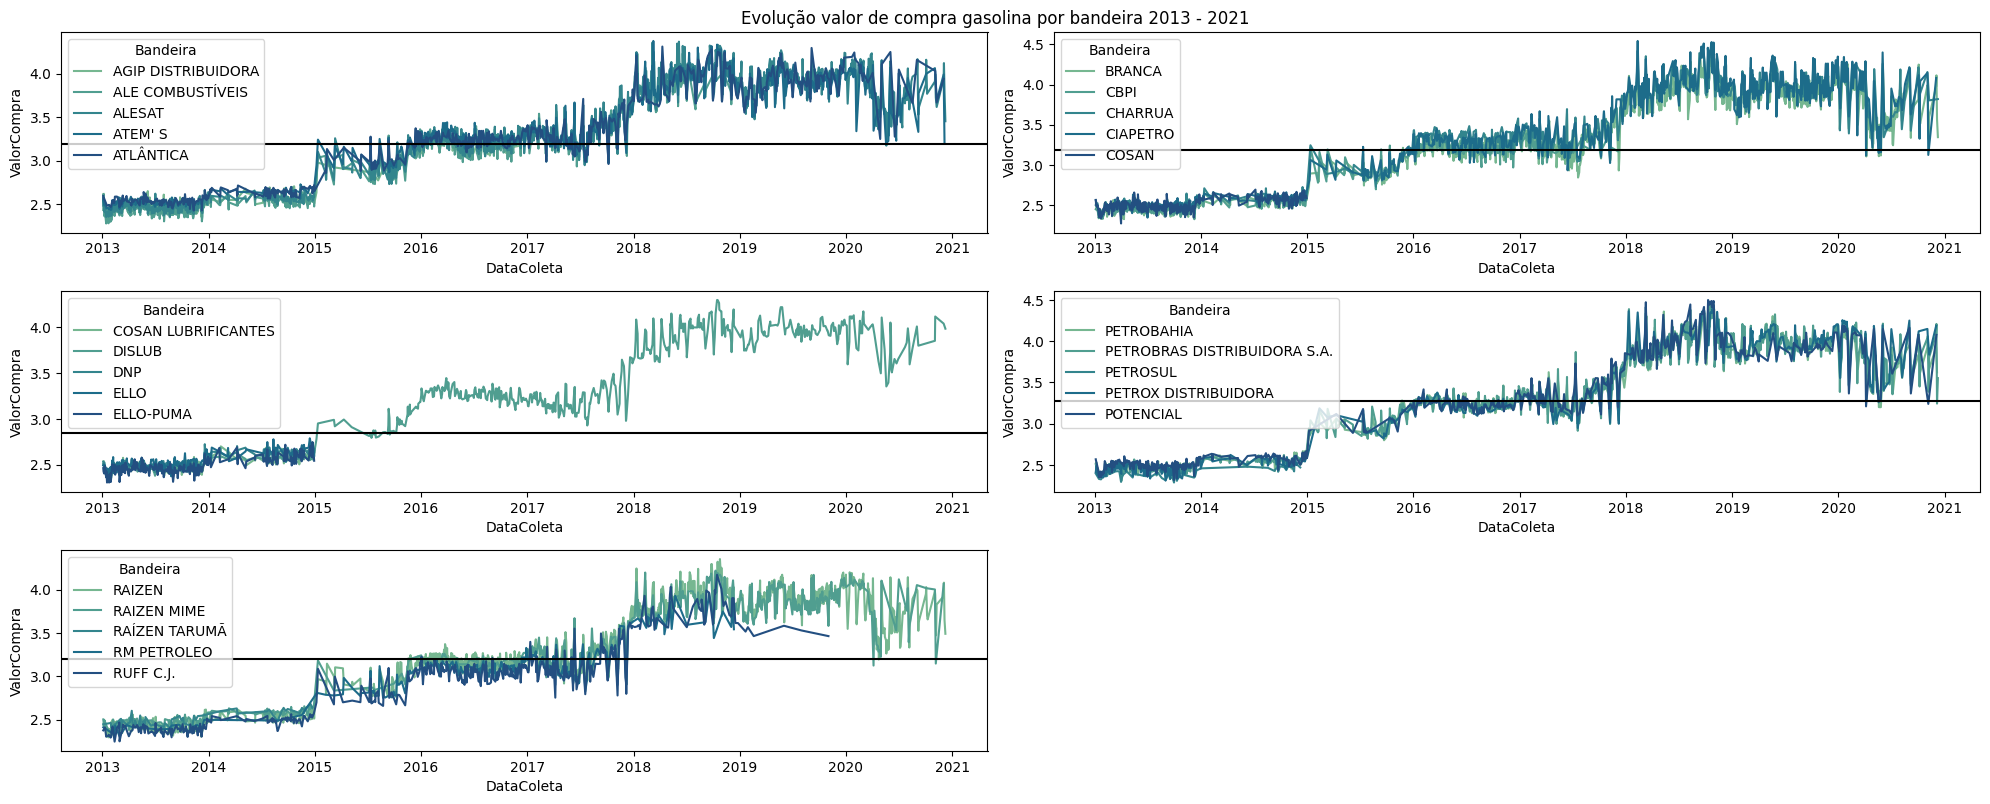

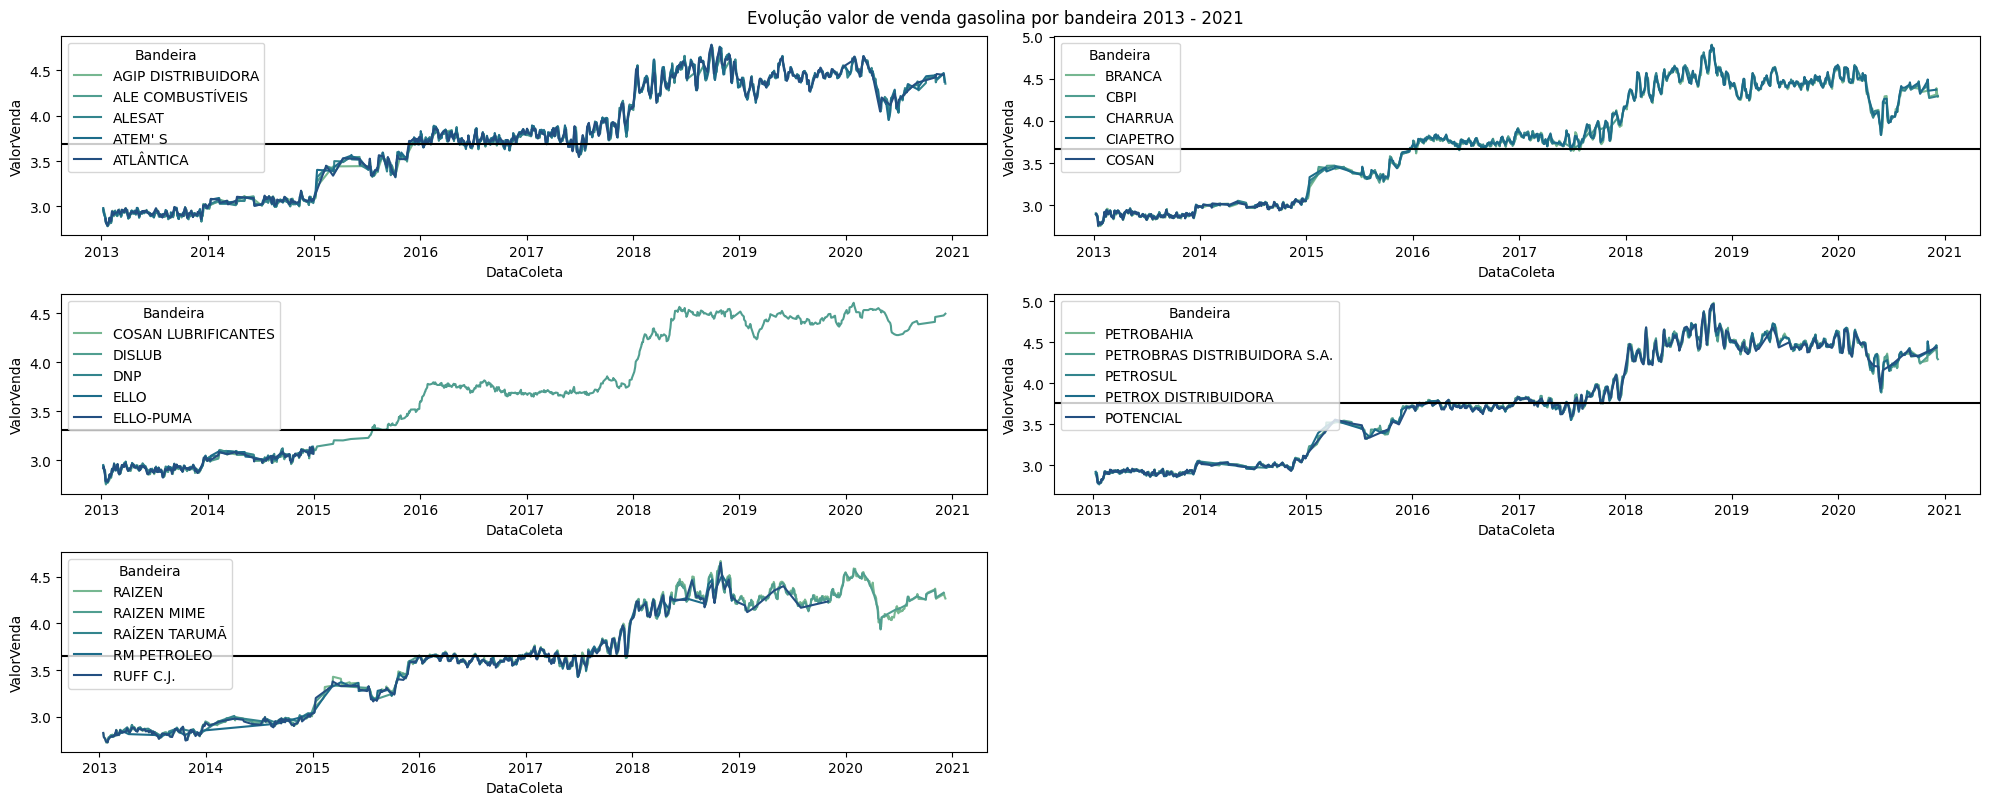

In [19]:
bandeiras = list(media_compra.index.get_level_values(1).unique()) 

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por bandeira 2013 - 2021')
mv_av_periods = 2

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_bandeira.png', dpi = 150)
plt.show()


#------------------------------------------------------------------------------------------------------------------------------------------------------------


plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por bandeira 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_bandeira.png', dpi = 150)
plt.show()

#### Conclusões
>-Semelhante a análise por estado, as bandeiras ao longo do tempo não demonstraram diferença significativa entre si.
>
>**-Será que a evolução da inflação (IPCA) foi responsável por esse aumento?**

## Inflação (IPCA)

In [ ]:
media_compra = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis.dropna(axis = 0).groupby(by = 'DataColeta')['ValorVenda'].mean()

# ARIMA

## Criação Modelo ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#Buscando pelo melhor padrão do ARIMA
import warnings
warnings.filterwarnings("ignore")
configs = [(7, 1, 7), (15, 1, 15), (30, 1, 30)]
best_error = 100
for config in configs:
    mod = ARIMA(media_valores, order = config).fit()
    mse_error = (mod.resid ** 2).mean()
    if mse_error < best_error:
        best = mse_error
        print(f'A config {config} é a melhor até agora.\ncom o MSE de {round(mse_error, 5)}')
        best_config = config

In [ ]:
#Separando Treino (Train) e Teste (Test)
train_size = int(((2/3) * len(media_valores)))
train_data = media_valores[:train_size]
test_data = media_valores[train_size:]


#Gerando Parâmetros do Modelo
arima_model_train_set = ARIMA(train_data, order = best_config).fit()

model_params = arima_model_train_set.params

## Avaliando Modelo nos Dados de Teste

In [ ]:
arima_model_test_set = ARIMA(test_data, order = best_config).fit(model_params)

In [ ]:
plt.figure(figsize=(10,4))
plt.ylabel('ValorCompra')
plt.plot(train_data, label = 'treino')
plt.plot(test_data, label = 'teste')
plt.plot(arima_model_test_set.predict()[1:], label ='previsão')
plt.legend()

In [ ]:
previsao = arima_model_test_set.predict()[1:]

df_validacao = pd.DataFrame(test_data)
df_validacao['previsao'] = previsao
df_validacao.dropna(axis=0, inplace=True)
df_validacao['dif'] = df_validacao.previsao - df_validacao.ValorCompra
df_validacao

In [ ]:
import sklearn.metrics as metrics    

In [ ]:
metrics.mean_absolute_percentage_error(df_validacao.ValorCompra, df_validacao.previsao) * 100

In [ ]:
metrics.mean_absolute_error(df_validacao.ValorCompra, df_validacao.previsao)

In [ ]:
metrics.mean_squared_error(df_validacao.ValorCompra, df_validacao.previsao)

# Testando com Novos Dados

In [ ]:
novos_dados = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_teste/')
float_converter(['ValorCompra','ValorVenda'], novos_dados)
add_dates(['DataColeta'], novos_dados)

In [ ]:
#Dados com problema, Valores de Compra nomeados como Valores de Venda
novos_dados['ValorCompra'].fillna(novos_dados.ValorVenda - (round(np.random.uniform(0.10, 0.12), 3) * novos_dados.ValorVenda), inplace=True)
novos_dados.describe()

In [ ]:
novos_dados = novos_dados.groupby(by='DataColeta')['ValorCompra'].mean()

In [ ]:
novos_dados.describe()

In [ ]:
modelo = ARIMA(novos_dados, order = best_config).fit(model_params)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(novos_dados, label= 'real')
plt.plot(modelo.predict()[1:], label='previsão')
plt.legend()

In [ ]:
modelo.forecast(1)